# HOML CHAPTER 3 NOTES
# ~~ Classification Intro~~

## DATASET DETAILS
### MNIST
- 70,000 Images shuffled and 'split'
- First 60,000 pre-set for training
- Next 10,000 for testing

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False) #fetch_openml returns pandasdf by default unless as_frame=False
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(type(mnist))
print(type(X))
print(X.shape)
# Each image has 784 features, 784=28*28px wide. Each feature represents a pixel's intensity (0-255)

<class 'sklearn.utils.Bunch'>
<class 'numpy.ndarray'>
(70000, 784)


<class 'numpy.ndarray'>


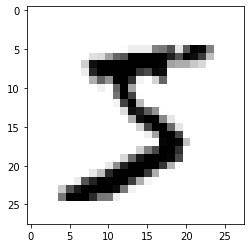

<class 'str'>
5


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0] #WILL FAIL IF X IS DF
print(type(some_digit))
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap='binary') #colormap
# plt.axis("off")
plt.show()
# Check the label 'target' column of the mnist set
print(type(y[0]))
# Convert y into integers to avoid errors later on
y = y.astype(np.uint8)
print(y[0])

### SHUFFLING THE DATASET
For the dataset to be effective, the dataset is shuffled. This is not applicable for time-series classification jobs, however.  
This is because some algorithms are sensitive to the order of training instances. They may perform badly if trained with many similar instances in a row.  



In [4]:
# Split the data into a test set and training set.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## BINARY CLASSIFIER
Classify X and NOT-X

### SGDC: Stochastic Gradient Descent Classifier
Verbatim from the book: SGDC 
- Efficiently handles large datasets
- As it deals with training data independently
- Good online learner

In [5]:
# Create a new list of labels. If the number is '5', the label is True
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Validate the fitting
sgd_clf.predict([some_digit])


array([ True])

## PERFORMANCE MEASURES (CLASSIFICATION)
Classification models are more difficult to evaluate. These are some performance measures to evaluate them.
### CROSS VALIDATION
### CONFUSION MATRIX
### PRECISION AND RECALL
### ROC CURVE
### MULTICLASS CLASSIFICATION
### ERROR ANALYSIS

### CROSS VALIDATION
- Similar to Chp 2
WARNING: High accuracy may be due to inherent probability, not due to model accuracy.
Accuracy as a measure is not reccomended for Classification Models, especially with skewed datasets like this one.  
The skew comes from certain classes (5/!5) being more frequent than others

For a NOT-5 classifier...
- 90% accuracy is as good as guessing randomly since 1 in 10 images are a '5'.

In [7]:
 from sklearn.model_selection import cross_val_score
 cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [8]:
# Demonstration of accuracy != good model using a 'bad model'
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
#endclass
never5clf = Never5Classifier()
cross_val_score(never5clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### CONFUSION MATRIX
Count the number of times A is counted as !A/B.

The sklearn confusion matrix returns a matrix whereby:
- Row -> actual class
- Col -> predicted class  

We can use other metrics to quanitfy effectiveness. 
Precision -> how many correct?
Recall -> how many missed?
F1 Score-> how similar are precision & recall?

<u>PRECISION</u>  
Let True-pos = TP, False-pos = FP  
precison = TP/(TP+FP)

<u>RECALL</u>  
recall = TP/(TP+FN)  
^ measures the true positive rate

<u>F1 SCORE</u>  
F1 = 2(PRECISION*RECALL)/(PRECISION+RECALL)

In [9]:
from sklearn.model_selection import cross_val_predict
y_train_predictions = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,  y_train_predictions)
# (0,0)-> non-5 correctly classified
# (0,1)-> non-5 wrongly classified as 5
# (1,0)-> 5 wrongly classified

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
vps = precision_score(y_train_5, y_train_predictions)
vrs = recall_score(y_train_5, y_train_predictions)
f1score = f1_score(y_train_5, y_train_predictions)
print(vps)
print(vrs)
print(f1score)

0.8370879772350012
0.6511713705958311
0.7325171197343846


### TRADE-OFFS: PRECISION AND RECALL

Precision -> How accurate
Recall -> How many get missed out

Higher precision = Higher chance of false positives = Lower 

SGDClassifier classifies based on a threshold -> score calculated by a decision fn


In [11]:
# Call .decision_function to get scores for each instance
# Filter the numpy array
y_scores = sgd_clf.decision_function([some_digit])
print(type(y_scores)) # FYI
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)


<class 'numpy.ndarray'>
[ True]


In [12]:
# Higher threshold should cause prediction to be false
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [13]:
# CROSS VALIDATE decision_function ie decision score as a metric
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
# Plot a Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print(type(precisions), type(recalls), type(thresholds))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


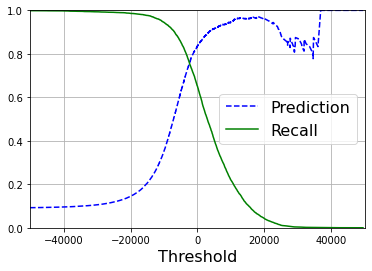

In [14]:
# Show the plot
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # NOTE: [:-1]
    plt.plot(thresholds, precisions[:-1], "b--", label="Prediction")
    plt.plot(thresholds, recalls[:-1],"g-", label='Recall')
    # Useful utlities
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])           

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

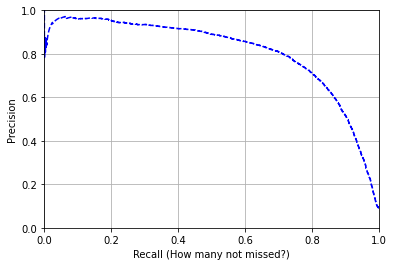

In [15]:
# Plot Precision against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b--")
    plt.xlabel("Recall (How many not missed?)")
    plt.ylabel("Precision")
    plt.axis([0,1,0,1]) # Force-set the scale to be 0-1 for x and y axes respectively
    plt.grid(True)

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [16]:
# Aim for 90% precision (arbitrary)
# argmax to give the first index where the condition is met
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)] # returns ~8000
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### ROC CURVE
The Receiver Operating Characteristic is often used for binary classifiers.  
It plots the **true positive rate** (TPR == recall) against the **false positive rate** (FPR).  
FPR = 1 - (True Negative Rate) // TPR == specificity  
ROC plots sensitivity (recall) to (1-specificity)

In a ROC graph, the straight line indicates a purely-random classifier.  
The further the model from the line, the better. (Maximise area under the curve)  

>> When to use ROC or PR curve?  
Book: Rule of thumb -> PR preferable to ROC when positive class is rare or false positives matter more than false negatives  


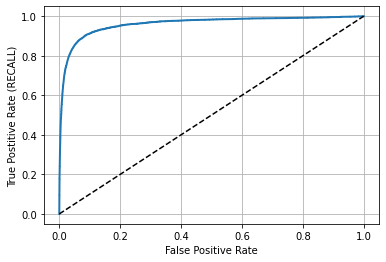

0.9604938554008616


In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Postitive Rate (RECALL)")
    plt.grid(True)
plot_roc_curve(fpr, tpr, thresholds)
plt.show()

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))

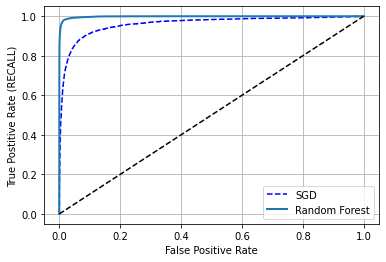

0.9983436731328145


In [18]:
# Using a Random Forest Classifier to demonstrate different ROCs
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
# predict_proba(bilities) in absense of decision_function()
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:,-1]
# Plot curves
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b--", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()
# Calc AUC
print(roc_auc_score(y_train_5, y_scores_forest))

## Multi-Class Classification

One vs Rest, One vs One -> If we only use binary classifiers  


In [19]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
print(svm_clf.predict([some_digit]))


[5]


In [20]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores)) # Show the highest scoring instance of n VS m
print(svm_clf.classes_) # Show the types of classes the svm has

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5
[0 1 2 3 4 5 6 7 8 9]


In [21]:
# Specifying OneVRest or OneVOne for Binary-Only classifiers...
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
# Show the results
print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))
# For models that support multi-class classification natively...
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit])) 

[5]
10
[3]


In [22]:
# Show the scores for each class
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [23]:
# As usual, cross validate
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [24]:
# Scale inputs for higher accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
result = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
print(result)

[0.8983 0.891  0.9018]


## ERROR ANALYSIS

For classification models, we want to find out the types of errors it will make.  

### CONFUSION MATRIX AGAIN
Use the conf matrix to spot discrepancies  


In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


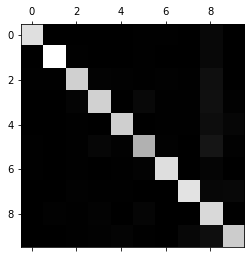

In [26]:
# Plot conf_mx -> absolute number of errors made
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

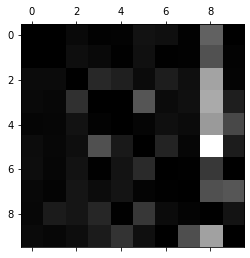

In [27]:
# Plot the relative errors / find error rate
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_mx / row_sums
# Fill diagonal with zeros to highlight only the errors
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap = plt.cm.gray)
plt.show()

In [30]:
# Utility from github
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

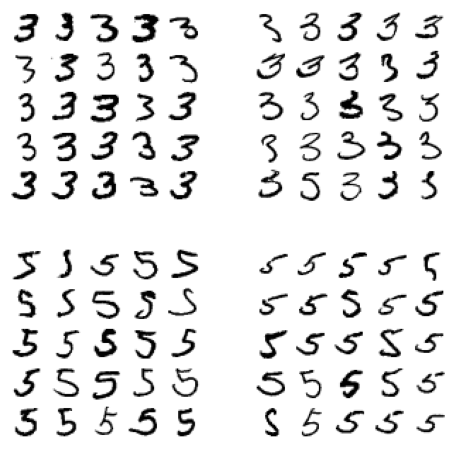

In [31]:
# Analysing individual errors
class_a, class_b = 3, 5
X_aa = X_train[(y_train == class_a) & (y_train_pred == class_a)]
X_ab = X_train[(y_train == class_a) & (y_train_pred == class_b)]
X_ba = X_train[(y_train == class_b) & (y_train_pred == class_a)]
X_bb = X_train[(y_train == class_b) & (y_train_pred == class_b)]
# Plot correctly classified 3s, 5s, wrong 3-5s...
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## MULTI-LABEL CLASSIFICATION
- A classification system where a piece of data gets various labels  
- Think of object recognition/face recognition software



In [32]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [33]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [34]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

0.976410265560605


## MULTIOUTPUT CLASSIFICATION

- Multilabel classification, where each label can be multiclass (>=1 value OK)  


In [35]:
# Demonstration using 'noise remover' as a context
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
# The target/outcome/labels are the 'clean' number images here!
y_train_mod = X_train
y_test_mod = X_test

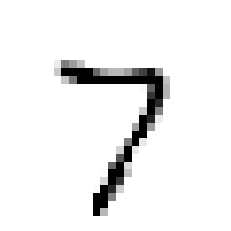

In [38]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
# Train the model
some_index = 0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)